In [1]:
from geoips.interfaces import readers as geoips_readers
import matplotlib.pyplot as plt
import numpy as np
import time

In [2]:
reader = geoips_readers.get_plugin("geoips_aviris_ng")

In [3]:
data = reader(fnames=["/data/ang20170321t194012_rfl_v2p5/ang20170321t194012_corr_v2p5_img"])

In [4]:
data

{'AVIRIS-NG-L1-RADIANCE': <xarray.Dataset> Size: 8GB
 Dimensions:           (y: 6499, x: 723)
 Coordinates:
   * y                 (y) float64 52kB 4.301e+06 4.301e+06 ... 4.178e+06
   * x                 (x) float64 6kB 6.584e+05 6.584e+05 ... 6.72e+05 6.72e+05
 Data variables: (12/428)
     latitude          (y, x) float64 38MB 4.301e+06 4.301e+06 ... 4.178e+06
     longitude         (y, x) float64 38MB 6.584e+05 6.584e+05 ... 6.72e+05
     time              (y, x) datetime64[ns] 38MB 2017-03-21T19:40:12 ... 2017...
     violet_376nm_rad  (y, x) float32 19MB nan nan nan nan ... nan nan nan nan
     violet_381nm_rad  (y, x) float32 19MB nan nan nan nan ... nan nan nan nan
     violet_386nm_rad  (y, x) float32 19MB nan nan nan nan ... nan nan nan nan
     ...                ...
     swir_2475nm_rad   (y, x) float32 19MB nan nan nan nan ... nan nan nan nan
     swir_2480nm_rad   (y, x) float32 19MB nan nan nan nan ... nan nan nan nan
     swir_2485nm_rad   (y, x) float32 19MB nan nan na

In [5]:
import pickle
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from functools import lru_cache
import hashlib
import xarray as xr

# Modified caching function for xarray datasets
def get_band_data_xarray(dataset, band_name, x_start, y_start, x_end, y_end):
    """Function to get band data from an xarray dataset."""
    data = dataset[band_name].isel(x=slice(x_start, x_end), y=slice(y_start, y_end)).values
    data = data.astype(float)
    data[data == -9999.] = np.nan
    return data

def get_cache_key_xarray(dataset, wavelength, px, py, window_size, offset_x, offset_y):
    """Generate a unique cache key based on input parameters."""
    # Use dataset attributes to create a unique identifier
    if hasattr(dataset, 'source_file_names'):
        dataset_id = str(dataset.source_file_names)
    else:
        dataset_id = str(dataset.dims)
    
    key_str = f"{dataset_id}_{wavelength}_{px}_{py}_{window_size}_{offset_x}_{offset_y}"
    return hashlib.md5(key_str.encode()).hexdigest()


In [20]:
def plot_wavelength_image_with_spectrum_xarray(dataset, wavelength, px=None, py=None, site_name="Site", 
                                       figsize=(16, 12), img_cmap='gray', arrow_position=None, 
                                       arrow_color='red', band_dictionary=None, cache_dir=None,
                                       window_size=200, offset_x=0, offset_y=0, north_arrow_angle=0,
                                       image_title=None, spectrum_title=None, 
                                       spectral_point_x=None, spectral_point_y=None, 
                                       show_crosshair=False, crosshair_color='white', 
                                       crosshair_alpha=0.5, crosshair_linewidth=1,
                                       center_x=None, center_y=None, vmin=None, vmax=None):
    """
    Plot imagery at the top and spectral curve at the bottom with connecting markers
    using xarray Dataset instead of GDAL.
    
    Parameters:
    -----------
    dataset : xarray.Dataset or dict
        The xarray dataset containing hyperspectral imagery or a dictionary with 'AVIRIS-NG-L1-RADIANCE' key
    wavelength : float
        The wavelength (in nm) to plot. The function will find the closest band.
    px, py : int, optional
        Pixel coordinates (x, y) indices for the point of interest. If None, spectral_point_x and spectral_point_y must be provided.
    site_name : str
        Name of the site/point being analyzed
    figsize : tuple
        Figure size (width, height) in inches
    img_cmap : str
        Colormap to use for the image. Default is 'gray'.
    arrow_position : tuple
        (x, y) position for the north arrow in data coordinates
    arrow_color : str
        Color of the arrow
    band_dictionary : dict
        Dictionary defining spectral regions. If None, a default will be used.
    cache_dir : str
        Directory to store cached data. If None, no caching will be used.
    window_size : int
        Size of the square window to extract around the center (in pixels)
    offset_x, offset_y : int
        Offset from the center of the image (in pixels)
    north_arrow_angle : float
        Angle of the north arrow from the y-axis in degrees (clockwise positive)
    image_title : str, optional
        Custom title for the image plot. If None, a default title will be used.
    spectrum_title : str, optional
        Custom title for the spectrum plot. If None, a default title will be used.
    spectral_point_x, spectral_point_y : int, optional
        Alternative way to specify the pixel coordinates for the spectral point. 
        If provided, these will override px and py.
    show_crosshair : bool, optional
        Whether to show a crosshair at the spectral point location. Default is False.
    crosshair_color : str, optional
        Color of the crosshair. Default is 'white'.
    crosshair_alpha : float, optional
        Transparency of the crosshair (0-1). Default is 0.5.
    crosshair_linewidth : float, optional
        Line width of the crosshair. Default is 1.
    center_x, center_y : int, optional
        Specific pixel coordinates to center the map on. If None, the map will be centered on the 
        middle of the image with any offset_x and offset_y applied.
    vmin, vmax : float, optional
        Minimum and maximum values for the colorbar. If None, the min and max values of the data will be used.
        
    Returns:
    --------
    fig : matplotlib figure object
    """
    # Start timing
    start_time = time.time()
    
    # Use spectral_point_x/y if provided, otherwise use px/py
    if spectral_point_x is not None and spectral_point_y is not None:
        px, py = spectral_point_x, spectral_point_y
    
    # Ensure px and py are provided
    if px is None or py is None:
        raise ValueError("Either (px, py) or (spectral_point_x, spectral_point_y) must be provided")
    
    # Get the dataset that contains the radiance data
    if isinstance(dataset, dict) and 'AVIRIS-NG-L1-RADIANCE' in dataset:
        data_ds = dataset['AVIRIS-NG-L1-RADIANCE']
    else:
        data_ds = dataset
    
    # Create cache directory if it doesn't exist
    if cache_dir is not None:
        os.makedirs(cache_dir, exist_ok=True)
        
        # Create cache filename based on input parameters
        cache_key = get_cache_key_xarray(data_ds, wavelength, px, py, window_size, offset_x, offset_y)
        if center_x is not None and center_y is not None:
            cache_key += f"_center_{center_x}_{center_y}"
        cache_path = os.path.join(cache_dir, f"{cache_key}.pkl")
        
        # Try to load from cache
        if os.path.exists(cache_path):
            try:
                #print(f"Loading cached data from {cache_path}")
                with open(cache_path, 'rb') as f:
                    cache_data = pickle.load(f)
                    
                    # Extract all needed data from cache
                    band_names = cache_data['band_names']
                    band_centers = cache_data['band_centers']
                    spectrum = cache_data['spectrum']
                    closest_band_idx = cache_data['closest_band_idx']
                    closest_band_name = cache_data['closest_band_name']
                    actual_wavelength = cache_data['actual_wavelength']
                    nrows, ncols = cache_data['dimensions']
                    x_start, x_end, y_start, y_end = cache_data['window_coords']
                    band_data = cache_data['band_data']
                    window_extent = cache_data['window_extent']
                    x_coord, y_coord = cache_data['pixel_coords']
                    
                    cached_data_loaded = True
                    #print(f"Cache loaded in {time.time() - start_time:.2f} seconds")
            except Exception as e:
                print(f"Error loading cache: {e}")
                cached_data_loaded = False
        else:
            cached_data_loaded = False
    else:
        cached_data_loaded = False
    
    # If cache wasn't loaded, compute the data
    if not cached_data_loaded:
        # Get dimensions
        nrows = data_ds.dims['y']
        ncols = data_ds.dims['x']
        
        # Extract band information from variable names
        band_names = [var for var in data_ds.data_vars if 'nm_rad' in var]
        
        # Extract wavelengths from band names
        band_centers = []
        for name in band_names:
            # Extract wavelength from band name (e.g., "violet_376nm_rad" -> 376)
            parts = name.split('_')
            for part in parts:
                if 'nm' in part:
                    band_centers.append(float(part.replace('nm', '')))
                    break
        
        # Find the band closest to the requested wavelength
        closest_band_idx = np.argmin(np.abs(np.array(band_centers) - wavelength))
        closest_band_name = band_names[closest_band_idx]
        actual_wavelength = band_centers[closest_band_idx]
        
        # Get the full spectrum for the selected point
        #print("Extracting spectral data...")
        spectrum = []
        for band_name in band_names:
            pixel_data = data_ds[band_name].isel(x=px, y=py).values
            spectrum.append(float(pixel_data))
        #print(f"Spectral data extracted in {time.time() - start_time:.2f} seconds")
        
        # Calculate the window coordinates with offset
        # Determine the center point for the window
        if center_x is not None and center_y is not None:
            # Use the specified center coordinates
            center_x_with_offset = center_x + offset_x
            center_y_with_offset = center_y + offset_y
        else:
            # Use the default center (middle of the image) with offset
            center_x_with_offset = (ncols // 2) + offset_x
            center_y_with_offset = (nrows // 2) + offset_y
        
        # Calculate window boundaries
        half_window = window_size // 2
        x_start = max(0, center_x_with_offset - half_window)
        x_end = min(ncols, center_x_with_offset + half_window)
        y_start = max(0, center_y_with_offset - half_window)
        y_end = min(nrows, center_y_with_offset + half_window)
        
        # Read only the window of interest for the selected band
        #print(f"Loading band {closest_band_name} for image display...")
        # Using the function without caching
        band_data = get_band_data_xarray(data_ds, closest_band_name, x_start, y_start, x_end, y_end)
        #print(f"Band data loaded in {time.time() - start_time:.2f} seconds")
        
        # Get coordinate values for the window extent
        x_coords = data_ds.x.values
        y_coords = data_ds.y.values
        
        # Calculate extent for the window
        window_extent = [
            x_coords[x_start],
            x_coords[x_end-1],
            y_coords[y_end-1],
            y_coords[y_start]
        ]
        
        # Get the real-world coordinates of the pixel
        x_coord = data_ds.x.values[px]
        y_coord = data_ds.y.values[py]
        
        # Save to cache if enabled
        if cache_dir is not None:
            cache_data = {
                'band_names': band_names,
                'band_centers': band_centers,
                'spectrum': spectrum,
                'closest_band_idx': closest_band_idx,
                'closest_band_name': closest_band_name,
                'actual_wavelength': actual_wavelength,
                'dimensions': (nrows, ncols),
                'window_coords': (x_start, x_end, y_start, y_end),
                'band_data': band_data,
                'window_extent': window_extent,
                'pixel_coords': (x_coord, y_coord)
            }
            with open(cache_path, 'wb') as f:
                pickle.dump(cache_data, f)
            #print(f"Data cached to {cache_path}")
    
    # Default band dictionary if none provided
    if band_dictionary is None:
        band_dictionary = {
            "visible-violet": {'lower': 375, 'upper': 450, 'color': 'violet'},
            "visible-blue": {'lower': 450, 'upper': 485, 'color': 'blue'},
            "visible-cyan": {'lower': 485, 'upper': 500, 'color': 'cyan'},
            "visible-green": {'lower': 500, 'upper': 565, 'color': 'green'},
            "visible-yellow": {'lower': 565, 'upper': 590, 'color': 'yellow'},
            "visible-orange": {'lower': 590, 'upper': 625, 'color': 'orange'},
            "visible-red": {'lower': 625, 'upper': 740, 'color': 'red'},
            "near-infrared": {'lower': 740, 'upper': 1100, 'color': 'gray'},
            "shortwave-infrared": {'lower': 1100, 'upper': 2500, 'color': 'white'}
        }
    
    # Create a DataFrame for the spectrum
    spectrum_df = pd.DataFrame({
        "Band name": band_names,
        "Band center (nm)": band_centers,
        f"{site_name} radiance": spectrum
    })
    
    # Create the figure - this part is always executed (not cached)
    fig = plt.figure(figsize=figsize)
    
    # Create GridSpec with different height ratios
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])
    
    # Title font dictionary
    titlefont = {'fontsize': 16, 'fontweight': 2,
                 'verticalalignment': 'baseline', 'horizontalalignment': 'center'}
    
    # Top subplot for the image
    ax_image = fig.add_subplot(gs[0])
    
    # Plot the image with vmin and vmax if provided
    im = ax_image.imshow(band_data, cmap=img_cmap, extent=window_extent, vmin=vmin, vmax=vmax)
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax_image)
    cbar.set_label('Radiance', fontsize=12)
    
    # Check if the point is within the window
    point_in_window = (x_start <= px < x_end) and (y_start <= py < y_end)
    
    # Mark the selected pixel on the image if it's within the window
    if point_in_window:
        ax_image.plot(x_coord, y_coord, 'ro', markersize=10, markeredgecolor='white')
    
    # Add crosshair if requested - do this regardless of whether point is in window
    if show_crosshair and point_in_window:
        #print(f"Drawing crosshair at coordinates ({x_coord}, {y_coord})")
        
        # Draw horizontal line across the full width of the displayed image
        ax_image.axhline(y=y_coord, color=crosshair_color, alpha=crosshair_alpha, 
                       linewidth=crosshair_linewidth, zorder=1)
        
        # Draw vertical line across the full height of the displayed image
        ax_image.axvline(x=x_coord, color=crosshair_color, alpha=crosshair_alpha, 
                       linewidth=crosshair_linewidth, zorder=1)
    elif show_crosshair and not point_in_window:
        print("Point is outside the current window. Crosshair not drawn.")
        
    # Image plot configuration
    # Use custom title if provided, otherwise use default
    if image_title is None:
        image_title = f"Imagery at {actual_wavelength:.2f} nm (Band {closest_band_name})"
    ax_image.set_title(image_title, fontdict=titlefont, pad=15)
    
    ax_image.set_xlabel('Easting (m)', fontsize=14)
    ax_image.set_ylabel('Northing (m)', fontsize=14)
    ax_image.tick_params(axis='both', which='major', labelsize=12)
    ax_image.grid(alpha=0.3, linestyle='--')
    
    # Add north arrow
    if arrow_position is None:
        # Default position in the upper left if not specified
        arrow_position = (window_extent[0] + 0.9 * (window_extent[1] - window_extent[0]), 
                          window_extent[3] - 0.2 * (window_extent[3] - window_extent[2]))
    
    arrow_length =   0.1 * (window_extent[3] - window_extent[2])  # 10% of the y-axis length
    
    # Calculate arrow components based on the angle
    import math
    angle_rad = math.radians(north_arrow_angle)
    dx = arrow_length * math.sin(angle_rad)
    
    dy = arrow_length * math.cos(angle_rad)
    
    # Draw the arrow with the specified angle
    ax_image.arrow(arrow_position[0], arrow_position[1], dx, dy, 
                  head_width=arrow_length/5, head_length=arrow_length/3, 
                  fc=arrow_color, ec=arrow_color, linewidth=3)
    
    # Add "North" text next to the arrow
    text_offset = 1.7 * arrow_length
    text_x = arrow_position[0] + dx * 1.6
    text_y = arrow_position[1] + dy * 1.6
    ax_image.text(text_x, text_y, 'N', fontsize=14, ha='center', color=arrow_color, fontweight='bold')
    
    # Bottom subplot for the spectrum
    ax_spectrum = fig.add_subplot(gs[1])
    
    # Plot the spectrum
    spectrum_df.plot(x='Band center (nm)', y=f"{site_name} radiance", 
                    ax=ax_spectrum, c='black', label='_nolegend_', legend=False)
    
    # Add shaders for band regions
    for region, limits in band_dictionary.items():
        ax_spectrum.axvspan(limits['lower'], limits['upper'], alpha=0.2, 
                           color=limits['color'], label=region)
    
    # Add water vapor region shaders
    ax_spectrum.axvspan(1340, 1445, alpha=0.1, color='blue', label='water vapor regions')
    ax_spectrum.axvspan(1790, 1955, alpha=0.1, color='blue')
    
    # Add vertical line at the selected wavelength
    ax_spectrum.axvline(x=actual_wavelength, color='red', linestyle='--', linewidth=2, 
                       label=f'Selected wavelength: {actual_wavelength:.2f} nm')
    
    # Mark the radiance value at the selected wavelength
    radiance_at_wavelength = spectrum[closest_band_idx]
    ax_spectrum.plot(actual_wavelength, radiance_at_wavelength, 'ro', markersize=8)
    
    # Spectrum plot configuration
    ax_spectrum.set_xlim(min(band_centers), max(band_centers))
    ax_spectrum.set_ylabel("Radiance", fontsize=16)
    ax_spectrum.set_xlabel("Wavelength (nm)", fontsize=16)
    ax_spectrum.tick_params(axis='both', which='major', labelsize=14)
    ax_spectrum.grid('on', alpha=0.25)
    
    # Use custom title if provided, otherwise use default
    if spectrum_title is None:
        spectrum_title = f"Spectral Profile at {site_name} (x={px}, y={py})"
    ax_spectrum.set_title(spectrum_title, fontdict=titlefont, pad=10)
    
    # Add legend to spectrum plot
    legend = ax_spectrum.legend(prop={'size': 12}, loc='center left', 
                               bbox_to_anchor=(1.01, 0.5), ncol=1, framealpha=1)
    
    # Adjust layout
    plt.tight_layout()
    plt.subplots_adjust(right=0.85)
    
    #print(f"Total plot generation time: {time.time() - start_time:.2f} seconds")
    
    return fig

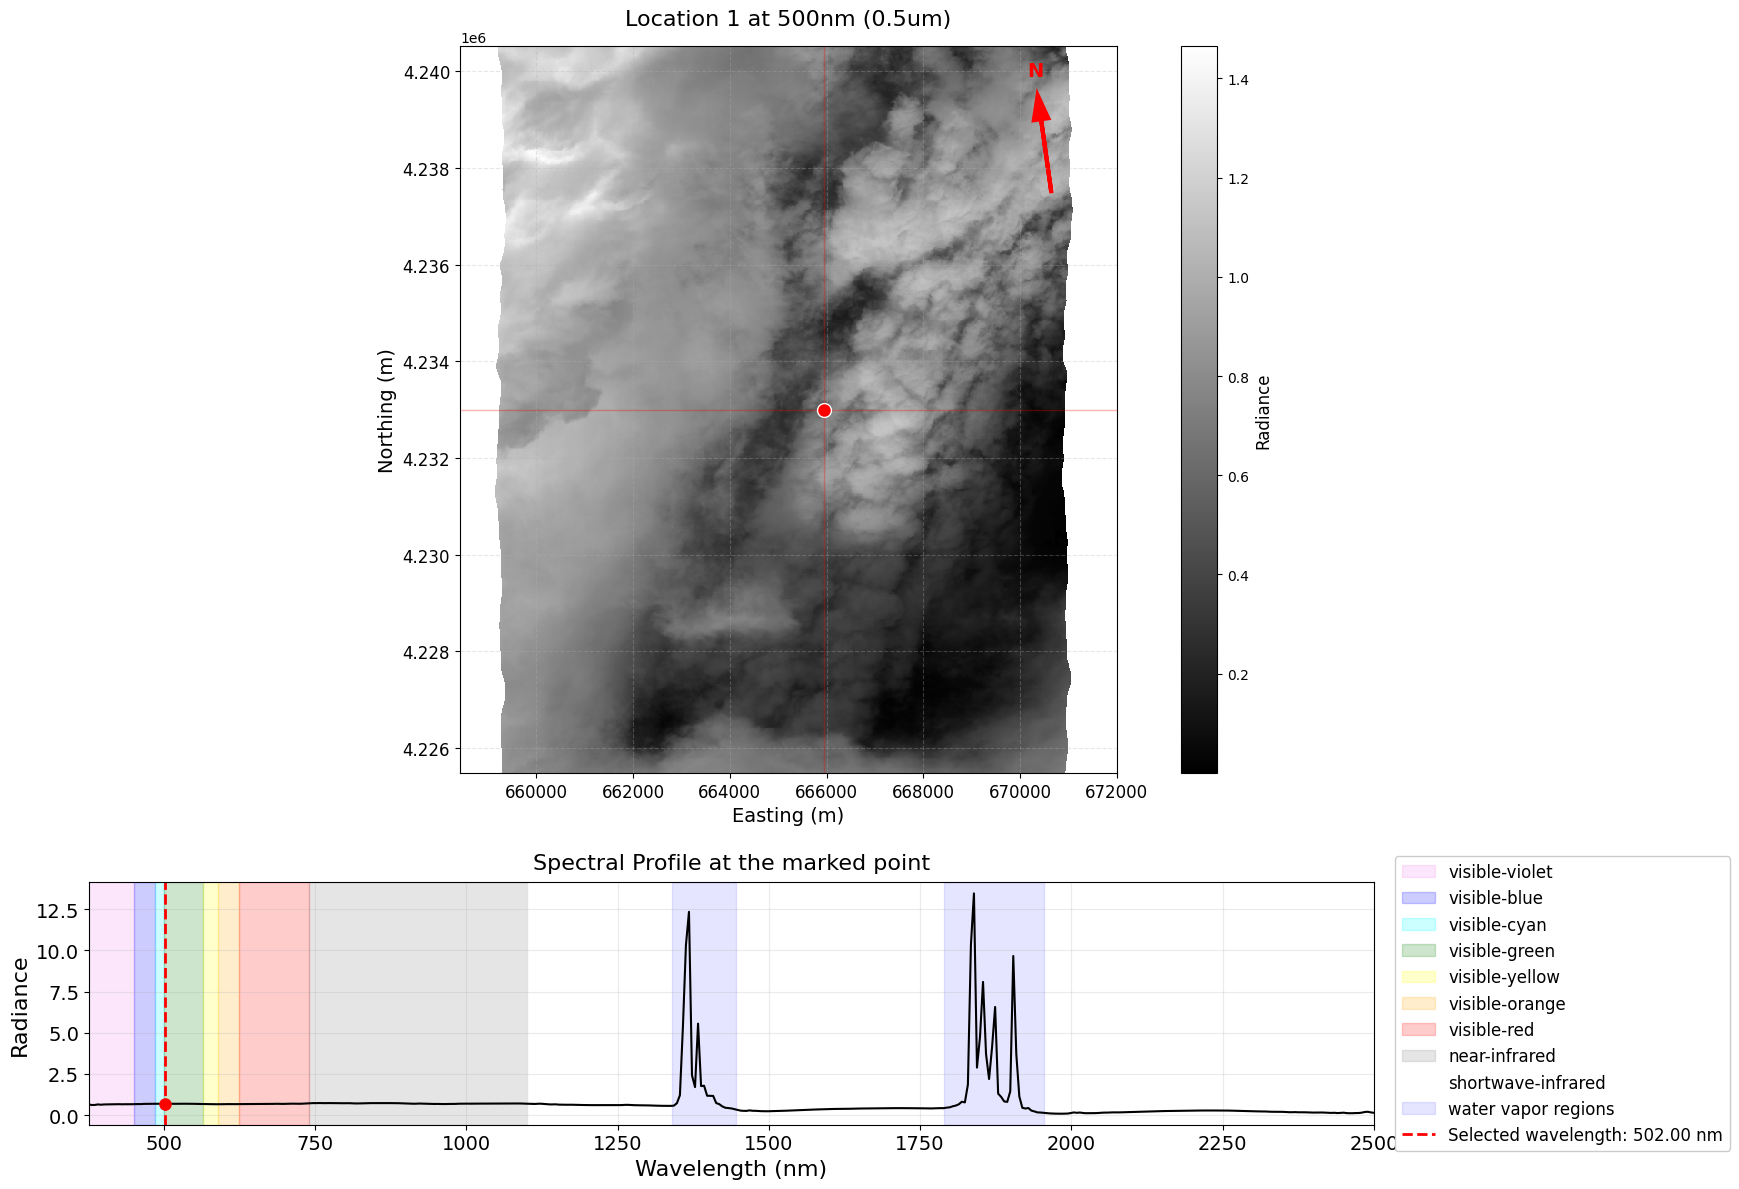

In [7]:
%matplotlib inline
fig1 = plot_wavelength_image_with_spectrum_xarray(
    dataset=data,
    wavelength=500,
    center_x=361,
    center_y=3600,
    px=400,
    py=3600,
    site_name="Site 1",
    window_size=800,
    north_arrow_angle=(360-8),
    image_title="Location 1 at 500nm (0.5um)",
    spectrum_title="Spectral Profile at the marked point",
    show_crosshair=True,
    crosshair_color='red',  # More visible color
    crosshair_alpha=0.3,    # Higher opacity
    crosshair_linewidth=1 # Thicker lines
)
plt.show()

In [8]:
data

{'AVIRIS-NG-L1-RADIANCE': <xarray.Dataset> Size: 8GB
 Dimensions:           (y: 6499, x: 723)
 Coordinates:
   * y                 (y) float64 52kB 4.301e+06 4.301e+06 ... 4.178e+06
   * x                 (x) float64 6kB 6.584e+05 6.584e+05 ... 6.72e+05 6.72e+05
 Data variables: (12/428)
     latitude          (y, x) float64 38MB 4.301e+06 4.301e+06 ... 4.178e+06
     longitude         (y, x) float64 38MB 6.584e+05 6.584e+05 ... 6.72e+05
     time              (y, x) datetime64[ns] 38MB 2017-03-21T19:40:12 ... 2017...
     violet_376nm_rad  (y, x) float32 19MB nan nan nan nan ... nan nan nan nan
     violet_381nm_rad  (y, x) float32 19MB nan nan nan nan ... nan nan nan nan
     violet_386nm_rad  (y, x) float32 19MB nan nan nan nan ... nan nan nan nan
     ...                ...
     swir_2475nm_rad   (y, x) float32 19MB nan nan nan nan ... nan nan nan nan
     swir_2480nm_rad   (y, x) float32 19MB nan nan nan nan ... nan nan nan nan
     swir_2485nm_rad   (y, x) float32 19MB nan nan na

In [9]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [10]:
def f(x):
    return x

In [11]:
interact(f, x=10);

interactive(children=(IntSlider(value=10, description='x', max=30, min=-10), Output()), _dom_classes=('widget-…

In [12]:
def slow_function(i):
    print(int(i),list(x for x in range(int(i)) if 
                str(x)==str(x)[::-1] and 
                str(x**2)==str(x**2)[::-1]))
    return

In [13]:
slow = interactive(slow_function, {'manual': True}, i=widgets.FloatSlider(min=1e4, max=1e6, step=1e4))
slow

interactive(children=(FloatSlider(value=10000.0, description='i', max=1000000.0, min=10000.0, step=10000.0), B…

In [14]:
wavelengths = [400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900]

In [15]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import time
from IPython.display import HTML

def create_wavelength_animation(dataset, wavelengths, px=None, py=None, site_name="Site", 
                               figsize=(16, 12), img_cmap='gray', arrow_position=None, 
                               arrow_color='red', band_dictionary=None, cache_dir=None,
                               window_size=200, offset_x=0, offset_y=0, north_arrow_angle=0,
                               image_title_template="Imagery at {wavelength:.2f} nm",
                               spectrum_title=None, spectral_point_x=None, spectral_point_y=None, 
                               show_crosshair=False, crosshair_color='white', 
                               crosshair_alpha=0.5, crosshair_linewidth=1,
                               center_x=None, center_y=None, frame_duration=500, 
                               repeat=True, save_path=None, dpi=100, vmin=None, vmax=None):
    """
    Create an animation that cycles through multiple wavelengths.
    
    Parameters:
    -----------
    dataset : xarray.Dataset or dict
        The xarray dataset containing hyperspectral imagery
    wavelengths : list
        List of wavelengths (in nm) to cycle through in the animation
    frame_duration : int, optional
        Duration of each frame in milliseconds. Default is 500ms.
    repeat : bool, optional
        Whether to repeat the animation. Default is True.
    save_path : str, optional
        Path to save the animation as a file. If None, animation is not saved.
    dpi : int, optional
        DPI for the saved animation. Default is 100.
    
    Other parameters are the same as plot_wavelength_image_with_spectrum_xarray.
    
    Returns:
    --------
    anim : matplotlib.animation.FuncAnimation object
    """
    # Create the initial figure with the first wavelength
    fig = plt.figure(figsize=figsize)
    
    # Create a function to update the figure for each frame
    def update(frame_num):
        plt.clf()  # Clear the figure
        wavelength = wavelengths[frame_num]
        
        # Create a custom image title if template is provided
        if image_title_template:
            custom_image_title = image_title_template.format(wavelength=wavelength)
        else:
            custom_image_title = None
        
        # Plot the new wavelength
        plot_wavelength_image_with_spectrum_xarray(
            dataset=dataset, 
            wavelength=wavelength, 
            px=px, 
            py=py, 
            site_name=site_name, 
            figsize=figsize, 
            img_cmap=img_cmap, 
            arrow_position=arrow_position, 
            arrow_color=arrow_color, 
            band_dictionary=band_dictionary, 
            cache_dir=cache_dir,
            window_size=window_size, 
            offset_x=offset_x, 
            offset_y=offset_y, 
            north_arrow_angle=north_arrow_angle,
            image_title=custom_image_title, 
            spectrum_title=spectrum_title, 
            spectral_point_x=spectral_point_x, 
            spectral_point_y=spectral_point_y, 
            show_crosshair=show_crosshair, 
            crosshair_color=crosshair_color, 
            crosshair_alpha=crosshair_alpha, 
            crosshair_linewidth=crosshair_linewidth,
            center_x=center_x, 
            center_y=center_y,
            vmin=vmin,
            vmax=vmax,
        )
        
        # Make sure the layout is tight
        plt.tight_layout()
        
        return fig,
    
    # Create the animation
    anim = animation.FuncAnimation(
        fig, 
        update, 
        frames=len(wavelengths),
        interval=frame_duration,  # milliseconds between frames
        repeat=repeat,
        blit=False  # redraw the whole figure each time
    )
    
    # Save the animation if a path is provided
    if save_path:
        print(f"Saving animation to {save_path}...")
        writer = animation.FFMpegWriter(fps=1000/frame_duration, bitrate=1800)
        anim.save(save_path, writer=writer, dpi=dpi)
        print("Animation saved successfully!")
    
    # Close the initial figure to avoid displaying it
    plt.close(fig)
    
    return anim

# Modified version of the original function to make it work better with animation
def plot_wavelength_image_with_spectrum_xarray(dataset, wavelength, px=None, py=None, site_name="Site", 
                                       figsize=(16, 12), img_cmap='gray', arrow_position=None, 
                                       arrow_color='red', band_dictionary=None, cache_dir=None,
                                       window_size=200, offset_x=0, offset_y=0, north_arrow_angle=0,
                                       image_title=None, spectrum_title=None, 
                                       spectral_point_x=None, spectral_point_y=None, 
                                       show_crosshair=False, crosshair_color='white', 
                                       crosshair_alpha=0.5, crosshair_linewidth=1,
                                       center_x=None, center_y=None, fig=None):
    """
    Modified version of the original function to work with animation.
    The main difference is that it can use an existing figure if provided.
    """
    # Start timing
    start_time = time.time()
    
    # Use spectral_point_x/y if provided, otherwise use px/py
    if spectral_point_x is not None and spectral_point_y is not None:
        px, py = spectral_point_x, spectral_point_y
    
    # Ensure px and py are provided
    if px is None or py is None:
        raise ValueError("Either (px, py) or (spectral_point_x, spectral_point_y) must be provided")
    
    # Get the dataset that contains the radiance data
    if isinstance(dataset, dict) and 'AVIRIS-NG-L1-RADIANCE' in dataset:
        data_ds = dataset['AVIRIS-NG-L1-RADIANCE']
    else:
        data_ds = dataset
    
    # Create cache directory if it doesn't exist
    if cache_dir is not None:
        os.makedirs(cache_dir, exist_ok=True)
        
        # Create cache filename based on input parameters
        cache_key = get_cache_key_xarray(data_ds, wavelength, px, py, window_size, offset_x, offset_y)
        if center_x is not None and center_y is not None:
            cache_key += f"_center_{center_x}_{center_y}"
        cache_path = os.path.join(cache_dir, f"{cache_key}.pkl")
        
        # Try to load from cache
        if os.path.exists(cache_path):
            try:
                with open(cache_path, 'rb') as f:
                    cache_data = pickle.load(f)
                    
                    # Extract all needed data from cache
                    band_names = cache_data['band_names']
                    band_centers = cache_data['band_centers']
                    spectrum = cache_data['spectrum']
                    closest_band_idx = cache_data['closest_band_idx']
                    closest_band_name = cache_data['closest_band_name']
                    actual_wavelength = cache_data['actual_wavelength']
                    nrows, ncols = cache_data['dimensions']
                    x_start, x_end, y_start, y_end = cache_data['window_coords']
                    band_data = cache_data['band_data']
                    window_extent = cache_data['window_extent']
                    x_coord, y_coord = cache_data['pixel_coords']
                    
                    cached_data_loaded = True
            except Exception as e:
                print(f"Error loading cache: {e}")
                cached_data_loaded = False
        else:
            cached_data_loaded = False
    else:
        cached_data_loaded = False
    
    # If cache wasn't loaded, compute the data
    if not cached_data_loaded:
        # Get dimensions
        nrows = data_ds.dims['y']
        ncols = data_ds.dims['x']
        
        # Extract band information from variable names
        band_names = [var for var in data_ds.data_vars if 'nm_rad' in var]
        
        # Extract wavelengths from band names
        band_centers = []
        for name in band_names:
            # Extract wavelength from band name (e.g., "violet_376nm_rad" -> 376)
            parts = name.split('_')
            for part in parts:
                if 'nm' in part:
                    band_centers.append(float(part.replace('nm', '')))
                    break
        
        # Find the band closest to the requested wavelength
        closest_band_idx = np.argmin(np.abs(np.array(band_centers) - wavelength))
        closest_band_name = band_names[closest_band_idx]
        actual_wavelength = band_centers[closest_band_idx]
        
        # Get the full spectrum for the selected point
        spectrum = []
        for band_name in band_names:
            pixel_data = data_ds[band_name].isel(x=px, y=py).values
            spectrum.append(float(pixel_data))
        
        # Calculate the window coordinates with offset
        # Determine the center point for the window
        if center_x is not None and center_y is not None:
            # Use the specified center coordinates
            center_x_with_offset = center_x + offset_x
            center_y_with_offset = center_y + offset_y
        else:
            # Use the default center (middle of the image) with offset
            center_x_with_offset = (ncols // 2) + offset_x
            center_y_with_offset = (nrows // 2) + offset_y
        
        # Calculate window boundaries
        half_window = window_size // 2
        x_start = max(0, center_x_with_offset - half_window)
        x_end = min(ncols, center_x_with_offset + half_window)
        y_start = max(0, center_y_with_offset - half_window)
        y_end = min(nrows, center_y_with_offset + half_window)
        
        # Read only the window of interest for the selected band
        band_data = get_band_data_xarray(data_ds, closest_band_name, x_start, y_start, x_end, y_end)
        
        # Get coordinate values for the window extent
        x_coords = data_ds.x.values
        y_coords = data_ds.y.values
        
        # Calculate extent for the window
        window_extent = [
            x_coords[x_start],
            x_coords[x_end-1],
            y_coords[y_end-1],
            y_coords[y_start]
        ]
        
        # Get the real-world coordinates of the pixel
        x_coord = data_ds.x.values[px]
        y_coord = data_ds.y.values[py]
        
        # Save to cache if enabled
        if cache_dir is not None:
            cache_data = {
                'band_names': band_names,
                'band_centers': band_centers,
                'spectrum': spectrum,
                'closest_band_idx': closest_band_idx,
                'closest_band_name': closest_band_name,
                'actual_wavelength': actual_wavelength,
                'dimensions': (nrows, ncols),
                'window_coords': (x_start, x_end, y_start, y_end),
                'band_data': band_data,
                'window_extent': window_extent,
                'pixel_coords': (x_coord, y_coord)
            }
            with open(cache_path, 'wb') as f:
                pickle.dump(cache_data, f)
    
    # Default band dictionary if none provided
    if band_dictionary is None:
        band_dictionary = {
            "visible-violet": {'lower': 375, 'upper': 450, 'color': 'violet'},
            "visible-blue": {'lower': 450, 'upper': 485, 'color': 'blue'},
            "visible-cyan": {'lower': 485, 'upper': 500, 'color': 'cyan'},
            "visible-green": {'lower': 500, 'upper': 565, 'color': 'green'},
            "visible-yellow": {'lower': 565, 'upper': 590, 'color': 'yellow'},
            "visible-orange": {'lower': 590, 'upper': 625, 'color': 'orange'},
            "visible-red": {'lower': 625, 'upper': 740, 'color': 'red'},
            "near-infrared": {'lower': 740, 'upper': 1100, 'color': 'gray'},
            "shortwave-infrared": {'lower': 1100, 'upper': 2500, 'color': 'white'}
        }
    
    # Create a DataFrame for the spectrum
    spectrum_df = pd.DataFrame({
        "Band name": band_names,
        "Band center (nm)": band_centers,
        f"{site_name} radiance": spectrum
    })
    
    # Use existing figure or create a new one
    if fig is None:
        fig = plt.figure(figsize=figsize)
    
    # Create GridSpec with different height ratios
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])
    
    # Title font dictionary
    titlefont = {'fontsize': 16, 'fontweight': 2,
                 'verticalalignment': 'baseline', 'horizontalalignment': 'center'}
    
    # Top subplot for the image
    ax_image = fig.add_subplot(gs[0])
    
    # Plot the image
    im = ax_image.imshow(band_data, cmap=img_cmap, extent=window_extent)
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax_image)
    cbar.set_label('Radiance', fontsize=12)
    
    # Check if the point is within the window
    point_in_window = (x_start <= px < x_end) and (y_start <= py < y_end)
    
    # Mark the selected pixel on the image if it's within the window
    if point_in_window:
        ax_image.plot(x_coord, y_coord, 'ro', markersize=10, markeredgecolor='white')
    
    # Add crosshair if requested - do this regardless of whether point is in window
    if show_crosshair and point_in_window:
        # Draw horizontal line across the full width of the displayed image
        ax_image.axhline(y=y_coord, color=crosshair_color, alpha=crosshair_alpha, 
                       linewidth=crosshair_linewidth, zorder=1)
        
        # Draw vertical line across the full height of the displayed image
        ax_image.axvline(x=x_coord, color=crosshair_color, alpha=crosshair_alpha, 
                       linewidth=crosshair_linewidth, zorder=1)
        
    # Image plot configuration
    # Use custom title if provided, otherwise use default
    if image_title is None:
        image_title = f"Imagery at {actual_wavelength:.2f} nm (Band {closest_band_name})"
    ax_image.set_title(image_title, fontdict=titlefont, pad=15)
    
    ax_image.set_xlabel('Easting (m)', fontsize=14)
    ax_image.set_ylabel('Northing (m)', fontsize=14)
    ax_image.tick_params(axis='both', which='major', labelsize=12)
    ax_image.grid(alpha=0.3, linestyle='--')
    
    # Add north arrow
    if arrow_position is None:
        # Default position in the upper left if not specified
        arrow_position = (window_extent[0] + 0.9 * (window_extent[1] - window_extent[0]), 
                          window_extent[3] - 0.2 * (window_extent[3] - window_extent[2]))
    
    arrow_length = 0.1 * (window_extent[3] - window_extent[2])  # 10% of the y-axis length
    
    # Calculate arrow components based on the angle
    import math
    angle_rad = math.radians(north_arrow_angle)
    dx = arrow_length * math.sin(angle_rad)
    dy = arrow_length * math.cos(angle_rad)
    
    # Draw the arrow with the specified angle
    ax_image.arrow(arrow_position[0], arrow_position[1], dx, dy, 
                  head_width=arrow_length/5, head_length=arrow_length/3, 
                  fc=arrow_color, ec=arrow_color, linewidth=3)
    
    # Add "North" text next to the arrow
    text_offset = 1.7 * arrow_length
    text_x = arrow_position[0] + dx * 1.6
    text_y = arrow_position[1] + dy * 1.6
    ax_image.text(text_x, text_y, 'N', fontsize=14, ha='center', color=arrow_color, fontweight='bold')
    
    # Bottom subplot for the spectrum
    ax_spectrum = fig.add_subplot(gs[1])
    
    # Plot the spectrum
    spectrum_df.plot(x='Band center (nm)', y=f"{site_name} radiance", 
                    ax=ax_spectrum, c='black', label='_nolegend_', legend=False)
    
    # Add shaders for band regions
    for region, limits in band_dictionary.items():
        ax_spectrum.axvspan(limits['lower'], limits['upper'], alpha=0.2, 
                           color=limits['color'], label=region)
    
    # Add water vapor region shaders
    ax_spectrum.axvspan(1340, 1445, alpha=0.1, color='blue', label='water vapor regions')
    ax_spectrum.axvspan(1790, 1955, alpha=0.1, color='blue')
    
    # Add vertical line at the selected wavelength
    ax_spectrum.axvline(x=actual_wavelength, color='red', linestyle='--', linewidth=2, 
                       label=f'Selected wavelength: {actual_wavelength:.2f} nm')
    
    # Mark the radiance value at the selected wavelength
    radiance_at_wavelength = spectrum[closest_band_idx]
    ax_spectrum.plot(actual_wavelength, radiance_at_wavelength, 'ro', markersize=8)
    
    # Spectrum plot configuration
    ax_spectrum.set_xlim(min(band_centers), max(band_centers))
    ax_spectrum.set_ylabel("Radiance", fontsize=16)
    ax_spectrum.set_xlabel("Wavelength (nm)", fontsize=16)
    ax_spectrum.tick_params(axis='both', which='major', labelsize=14)
    ax_spectrum.grid('on', alpha=0.25)
    
    # Use custom title if provided, otherwise use default
    if spectrum_title is None:
        spectrum_title = f"Spectral Profile at {site_name} (x={px}, y={py})"
    ax_spectrum.set_title(spectrum_title, fontdict=titlefont, pad=10)
    
    # Add legend to spectrum plot
    legend = ax_spectrum.legend(prop={'size': 12}, loc='center left', 
                               bbox_to_anchor=(1.01, 0.5), ncol=1, framealpha=1)
    
    # Adjust layout
    plt.tight_layout()
    plt.subplots_adjust(right=0.85)
    
    return fig

In [18]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import time
import os
import io
from PIL import Image
from IPython.display import HTML

def create_wavelength_animation(dataset, wavelengths, px=None, py=None, site_name="Site", 
                               figsize=(16, 12), img_cmap='gray', arrow_position=None, 
                               arrow_color='red', band_dictionary=None, cache_dir=None,
                               window_size=200, offset_x=0, offset_y=0, north_arrow_angle=0,
                               image_title_template="Imagery at {wavelength:.2f} nm",
                               spectrum_title=None, spectral_point_x=None, spectral_point_y=None, 
                               show_crosshair=False, crosshair_color='white', 
                               crosshair_alpha=0.5, crosshair_linewidth=1,
                               center_x=None, center_y=None, frame_duration=500, 
                               repeat=True, save_path=None, dpi=100, vmin=None, vmax=None):
    """
    Create an animation that cycles through multiple wavelengths.
    """
    # Let's use a simpler approach - create and save individual frames, then combine them
    print("Generating frames for animation...")
    
    # Create a directory for temporary frames if saving
    if save_path:
        import tempfile
        temp_dir = tempfile.mkdtemp()
        print(f"Using temporary directory: {temp_dir}")
    
    # Generate each frame
    frames = []
    for i, wavelength in enumerate(wavelengths):
        print(f"Generating frame {i+1}/{len(wavelengths)} - wavelength: {wavelength}nm")
        
        # Calculate wavelength in micrometers for the title
        wavelength_um = wavelength / 1000
        
        # Create a custom image title if template is provided
        if image_title_template:
            custom_image_title = image_title_template.format(wavelength=wavelength, wavelength_um=wavelength_um)
        else:
            custom_image_title = None
        
        # Create a figure for this wavelength
        fig = plot_wavelength_image_with_spectrum_xarray(
            dataset=dataset, 
            wavelength=wavelength, 
            px=px, 
            py=py, 
            site_name=site_name, 
            figsize=figsize, 
            img_cmap=img_cmap, 
            arrow_position=arrow_position, 
            arrow_color=arrow_color, 
            band_dictionary=band_dictionary, 
            cache_dir=cache_dir,
            window_size=window_size, 
            offset_x=offset_x, 
            offset_y=offset_y, 
            north_arrow_angle=north_arrow_angle,
            image_title=custom_image_title, 
            spectrum_title=spectrum_title, 
            spectral_point_x=spectral_point_x, 
            spectral_point_y=spectral_point_y, 
            show_crosshair=show_crosshair, 
            crosshair_color=crosshair_color, 
            crosshair_alpha=crosshair_alpha, 
            crosshair_linewidth=crosshair_linewidth,
            center_x=center_x, 
            center_y=center_y,
            vmin=vmin,
            vmax=vmax,
        )
        
        # Save the figure to a buffer
        buf = io.BytesIO()
        fig.savefig(buf, format='png', dpi=dpi)
        buf.seek(0)
        
        # Load the image from the buffer
        img = Image.open(buf)
        frames.append(img)
        
        # If saving, also save to disk
        if save_path:
            frame_path = os.path.join(temp_dir, f"frame_{i:03d}.png")
            fig.savefig(frame_path, dpi=dpi)
        
        # Close the figure
        plt.close(fig)
    
    # Save the animation if a path is provided
    if save_path:
        print(f"Saving animation to {save_path}...")
        try:
            # Try to create a GIF using PIL
            gif_path = save_path.replace('.mp4', '.gif')
            frames[0].save(
                gif_path,
                save_all=True,
                append_images=frames[1:],
                optimize=False,
                duration=frame_duration,
                loop=0 if repeat else 1
            )
            print(f"Animation saved as GIF: {gif_path}")
            
            # Try to create an MP4 if ffmpeg is available
            try:
                import subprocess
                
                # Create a command to convert the frames to MP4
                cmd = [
                    'ffmpeg',
                    '-y',  # Overwrite output file if it exists
                    '-framerate', str(1000/frame_duration),
                    '-i', os.path.join(temp_dir, 'frame_%03d.png'),
                    '-c:v', 'libx264',
                    '-pix_fmt', 'yuv420p',
                    '-vf', 'pad=ceil(iw/2)*2:ceil(ih/2)*2',  # Ensure dimensions are even
                    save_path
                ]
                
                # Run the command
                subprocess.run(cmd, check=True)
                print(f"Animation saved as MP4: {save_path}")
            except Exception as e:
                print(f"Could not create MP4 (ffmpeg error): {e}")
                print("GIF version is available instead.")
                
        except Exception as e:
            print(f"Error saving animation: {e}")
    
    # Create an HTML animation for display in the notebook
    html_animation = create_html_animation(frames, frame_duration, repeat)
    
    return html_animation

def create_html_animation(frames, frame_duration, repeat=True):
    """
    Create an HTML animation from a list of PIL Image objects.
    """
    # Convert frames to base64-encoded strings
    import base64
    
    base64_frames = []
    for frame in frames:
        buf = io.BytesIO()
        frame.save(buf, format='PNG')
        buf.seek(0)
        img_str = base64.b64encode(buf.read()).decode('ascii')
        base64_frames.append(img_str)
    
    # Create HTML with JavaScript to display the animation
    html = """
    <div id="animation" style="display: inline-block;">
        <img id="animationImage" style="display: block;">
    </div>
    
    <script>
        var frames = {frames};
        var frameIndex = 0;
        var frameCount = frames.length;
        var frameDuration = {duration}; // milliseconds
        var repeat = {repeat};
        var animationImage = document.getElementById('animationImage');
        var animationRunning = true;
        
        function updateFrame() {{
            if (frameIndex >= frameCount) {{
                if (repeat) {{
                    frameIndex = 0;
                }} else {{
                    animationRunning = false;
                    return;
                }}
            }}
            
            animationImage.src = 'data:image/png;base64,' + frames[frameIndex];
            frameIndex++;
            
            if (animationRunning) {{
                setTimeout(updateFrame, frameDuration);
            }}
        }}
        
        // Start the animation
        updateFrame();
    </script>
    """.format(
        frames=str(base64_frames),
        duration=frame_duration,
        repeat=str(repeat).lower()
    )
    
    return HTML(html)

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt

# Define the wavelengths you want to cycle through
#wavelengths = [400, 500, 600, 700, 800, 900]  # Example wavelengths

# Create the animation
animation = create_wavelength_animation(
    dataset=data,
    wavelengths=wavelengths,
    center_x=361,
    center_y=3600,
    px=400,
    py=3600,
    site_name="Site 1",
    window_size=800,
    north_arrow_angle=(360-8),
    image_title_template="Location 1 at {wavelength:.0f}nm ({wavelength_um:.1f}um)",
    spectrum_title="Spectral Profile at the marked point",
    show_crosshair=True,
    crosshair_color='red',
    crosshair_alpha=0.3,
    crosshair_linewidth=1,
    frame_duration=100,  # .1 second per frame
    save_path="location1_wavelength_animation_slow.mp4",  # Optional: remove if you don't want to save
    vmin=0,
    vmax=1.8,
)

# The animation is already an HTML object and can be displayed directly
animation

Generating frames for animation...
Using temporary directory: /tmp/tmpu_i4kixd
Generating frame 1/11 - wavelength: 400nm
Generating frame 2/11 - wavelength: 450nm
Generating frame 3/11 - wavelength: 500nm
Generating frame 4/11 - wavelength: 550nm
Generating frame 5/11 - wavelength: 600nm
Generating frame 6/11 - wavelength: 650nm
Generating frame 7/11 - wavelength: 700nm
Generating frame 8/11 - wavelength: 750nm
Generating frame 9/11 - wavelength: 800nm
Generating frame 10/11 - wavelength: 850nm
Generating frame 11/11 - wavelength: 900nm
Saving animation to location1_wavelength_animation_slow.mp4...
Animation saved as GIF: location1_wavelength_animation_slow.gif


ffmpeg version 4.3.8-0+deb11u3 Copyright (c) 2000-2024 the FFmpeg developers
  built with gcc 10 (Debian 10.2.1-6)
  configuration: --prefix=/usr --extra-version=0+deb11u3 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab 

Animation saved as MP4: location1_wavelength_animation_slow.mp4


In [ ]:
wavelengths = [y["wavelength"] for y in [data["AVIRIS-NG-L1-RADIANCE"][x].attrs for x in data["AVIRIS-NG-L1-RADIANCE"].variables] if "wavelength" in y.keys()]

In [25]:
import ipywidgets as widgets
from ipywidgets import interactive, Layout, VBox, HBox, Tab
import matplotlib.pyplot as plt

def create_hyperspectral_widgets(dataset, default_values=None):
    """
    Create interactive widgets for the hyperspectral plotting function.
    
    Parameters:
    -----------
    dataset : xarray.Dataset
        The dataset to use for extracting coordinate ranges
    default_values : dict, optional
        Dictionary of default values to override widget defaults
    """
    
    # Set up default values
    defaults = {
        'wavelength': 500,
        'center_x': 361,
        'center_y': 3600,
        'px': 400,
        'py': 3600,
        'site_name': "Site 1",
        'window_size': 800,
        'north_arrow_angle': 352,
        'image_title': "Hyperspectral Image",
        'spectrum_title': "Spectral Profile at the marked point",
        'show_crosshair': True,
        'crosshair_color': 'red',
        'crosshair_alpha': 0.3,
        'crosshair_linewidth': 1
    }
    
    if default_values:
        defaults.update(default_values)
    
    # Try to get coordinate ranges from dataset
    try:
        if isinstance(dataset, dict) and 'AVIRIS-NG-L1-RADIANCE' in dataset:
            data = dataset['AVIRIS-NG-L1-RADIANCE']
        else:
            data = dataset
            
        x_max = int(data.sizes.get('x', data.sizes.get('longitude', 1000)))
        y_max = int(data.sizes.get('y', data.sizes.get('latitude', 1000)))
        
        # Try to get wavelength range
        if hasattr(data, 'wavelength'):
            wl_min = float(data.wavelength.min())
            wl_max = float(data.wavelength.max())
        else:
            wl_min, wl_max = 400, 2500
    except:
        x_max, y_max = 1000, 1000
        wl_min, wl_max = 400, 2500
    
    # Basic Parameters Tab
    wavelength_widget = widgets.FloatSlider(
        value=defaults['wavelength'],
        min=wl_min,
        max=wl_max,
        step=1,
        description='Wavelength (nm):',
        style={'description_width': 'initial'},
        layout=Layout(width='500px')
    )
    
    site_name_widget = widgets.Text(
        value=defaults['site_name'],
        description='Site Name:',
        style={'description_width': 'initial'},
        layout=Layout(width='300px')
    )
    
    # Position Parameters
    center_x_widget = widgets.IntSlider(
        value=defaults['center_x'],
        min=0,
        max=x_max,
        step=1,
        description='Center X:',
        style={'description_width': 'initial'},
        layout=Layout(width='400px')
    )
    
    center_y_widget = widgets.IntSlider(
        value=defaults['center_y'],
        min=0,
        max=y_max,
        step=1,
        description='Center Y:',
        style={'description_width': 'initial'},
        layout=Layout(width='400px')
    )
    
    px_widget = widgets.IntSlider(
        value=defaults['px'],
        min=0,
        max=x_max,
        step=1,
        description='Spectrum Point X:',
        style={'description_width': 'initial'},
        layout=Layout(width='400px')
    )
    
    py_widget = widgets.IntSlider(
        value=defaults['py'],
        min=0,
        max=y_max,
        step=1,
        description='Spectrum Point Y:',
        style={'description_width': 'initial'},
        layout=Layout(width='400px')
    )
    
    window_size_widget = widgets.IntSlider(
        value=defaults['window_size'],
        min=100,
        max=2000,
        step=50,
        description='Window Size:',
        style={'description_width': 'initial'},
        layout=Layout(width='400px')
    )
    
    # Display Parameters
    figsize_width = widgets.IntSlider(
        value=16,
        min=8,
        max=24,
        step=1,
        description='Figure Width:',
        style={'description_width': 'initial'},
        layout=Layout(width='300px')
    )
    
    figsize_height = widgets.IntSlider(
        value=12,
        min=6,
        max=18,
        step=1,
        description='Figure Height:',
        style={'description_width': 'initial'},
        layout=Layout(width='300px')
    )
    
    img_cmap_widget = widgets.Dropdown(
        options=['gray', 'viridis', 'plasma', 'inferno', 'magma', 'cividis', 'jet', 'hot', 'cool'],
        value='gray',
        description='Colormap:',
        style={'description_width': 'initial'},
        layout=Layout(width='200px')
    )
    
    # Titles
    image_title_widget = widgets.Text(
        value=defaults['image_title'],
        description='Image Title:',
        style={'description_width': 'initial'},
        layout=Layout(width='500px')
    )
    
    spectrum_title_widget = widgets.Text(
        value=defaults['spectrum_title'],
        description='Spectrum Title:',
        style={'description_width': 'initial'},
        layout=Layout(width='500px')
    )
    
    # North Arrow Parameters
    north_arrow_angle_widget = widgets.FloatSlider(
        value=defaults['north_arrow_angle'],
        min=0,
        max=360,
        step=1,
        description='North Arrow Angle:',
        style={'description_width': 'initial'},
        layout=Layout(width='400px')
    )
    
    arrow_color_widget = widgets.Dropdown(
        options=['red', 'blue', 'green', 'yellow', 'black', 'white', 'orange', 'purple'],
        value='red',
        description='Arrow Color:',
        style={'description_width': 'initial'},
        layout=Layout(width='200px')
    )
    
    # Crosshair Parameters
    show_crosshair_widget = widgets.Checkbox(
        value=defaults['show_crosshair'],
        description='Show Crosshair',
        style={'description_width': 'initial'}
    )
    
    crosshair_color_widget = widgets.Dropdown(
        options=['red', 'white', 'blue', 'green', 'yellow', 'black', 'orange', 'purple'],
        value=defaults['crosshair_color'],
        description='Crosshair Color:',
        style={'description_width': 'initial'},
        layout=Layout(width='200px')
    )
    
    crosshair_alpha_widget = widgets.FloatSlider(
        value=defaults['crosshair_alpha'],
        min=0.1,
        max=1.0,
        step=0.1,
        description='Crosshair Alpha:',
        style={'description_width': 'initial'},
        layout=Layout(width='300px')
    )
    
    crosshair_linewidth_widget = widgets.FloatSlider(
        value=defaults['crosshair_linewidth'],
        min=0.5,
        max=5.0,
        step=0.5,
        description='Crosshair Width:',
        style={'description_width': 'initial'},
        layout=Layout(width='300px')
    )
    
    # Color Scale Parameters
    vmin_widget = widgets.FloatText(
        value=None,
        description='V Min:',
        style={'description_width': 'initial'},
        layout=Layout(width='200px')
    )
    
    vmax_widget = widgets.FloatText(
        value=None,
        description='V Max:',
        style={'description_width': 'initial'},
        layout=Layout(width='200px')
    )
    
    # Offset Parameters
    offset_x_widget = widgets.IntSlider(
        value=0,
        min=-500,
        max=500,
        step=10,
        description='Offset X:',
        style={'description_width': 'initial'},
        layout=Layout(width='300px')
    )
    
    offset_y_widget = widgets.IntSlider(
        value=0,
        min=-500,
        max=500,
        step=10,
        description='Offset Y:',
        style={'description_width': 'initial'},
        layout=Layout(width='300px')
    )
    
    # Create tabs for organization
    basic_tab = VBox([
        HBox([wavelength_widget]),
        HBox([site_name_widget]),
        HBox([image_title_widget]),
        HBox([spectrum_title_widget])
    ])
    
    position_tab = VBox([
        HBox([center_x_widget, center_y_widget]),
        HBox([px_widget, py_widget]),
        HBox([window_size_widget]),
        HBox([offset_x_widget, offset_y_widget])
    ])
    
    display_tab = VBox([
        HBox([figsize_width, figsize_height]),
        HBox([img_cmap_widget]),
        HBox([vmin_widget, vmax_widget])
    ])
    
    arrow_crosshair_tab = VBox([
        HBox([north_arrow_angle_widget, arrow_color_widget]),
        HBox([show_crosshair_widget]),
        HBox([crosshair_color_widget]),
        HBox([crosshair_alpha_widget, crosshair_linewidth_widget])
    ])
    
    # Create tabbed interface
    tab = Tab()
    tab.children = [basic_tab, position_tab, display_tab, arrow_crosshair_tab]
    tab.set_title(0, 'Basic')
    tab.set_title(1, 'Position')
    tab.set_title(2, 'Display')
    tab.set_title(3, 'Arrow & Crosshair')
    
    # Create the interactive widget
    def plot_wrapper(wavelength, site_name, center_x, center_y, px, py, window_size,
                    figsize_width, figsize_height, img_cmap, image_title, spectrum_title,
                    north_arrow_angle, arrow_color, show_crosshair, crosshair_color,
                    crosshair_alpha, crosshair_linewidth, vmin, vmax, offset_x, offset_y):
        
        # Handle None values for vmin/vmax
        vmin = None if vmin == 0 else vmin
        vmax = None if vmax == 0 else vmax
        
        fig = plot_wavelength_image_with_spectrum_xarray(
            dataset=dataset,
            wavelength=wavelength,
            center_x=center_x,
            center_y=center_y,
            px=px,
            py=py,
            site_name=site_name,
            window_size=window_size,
            north_arrow_angle=north_arrow_angle,
            image_title=image_title,
            spectrum_title=spectrum_title,
            show_crosshair=show_crosshair,
            crosshair_color=crosshair_color,
            crosshair_alpha=crosshair_alpha,
            crosshair_linewidth=crosshair_linewidth,
            figsize=(figsize_width, figsize_height),
            img_cmap=img_cmap,
            arrow_color=arrow_color,
            vmin=vmin,
            vmax=vmax,
            offset_x=offset_x,
            offset_y=offset_y
        )
        plt.show()
        return fig
    
    # Create interactive widget with manual execution
    interactive_plot = interactive(
        plot_wrapper,
        {'manual': True, 'manual_name': 'Update Plot'},
        wavelength=wavelength_widget,
        site_name=site_name_widget,
        center_x=center_x_widget,
        center_y=center_y_widget,
        px=px_widget,
        py=py_widget,
        window_size=window_size_widget,
        figsize_width=figsize_width,
        figsize_height=figsize_height,
        img_cmap=img_cmap_widget,
        image_title=image_title_widget,
        spectrum_title=spectrum_title_widget,
        north_arrow_angle=north_arrow_angle_widget,
        arrow_color=arrow_color_widget,
        show_crosshair=show_crosshair_widget,
        crosshair_color=crosshair_color_widget,
        crosshair_alpha=crosshair_alpha_widget,
        crosshair_linewidth=crosshair_linewidth_widget,
        vmin=vmin_widget,
        vmax=vmax_widget,
        offset_x=offset_x_widget,
        offset_y=offset_y_widget
    )
    
    # Combine tabs and interactive widget
    full_widget = VBox([tab, interactive_plot.children[-1]])  # Only show the button
    interactive_plot.children = interactive_plot.children[:-1]  # Remove the button from original
    
    return VBox([tab, interactive_plot])

# Usage example:
# Assuming you have your dataset loaded as 'data'
# hyperspectral_widgets = create_hyperspectral_widgets(data)
# display(hyperspectral_widgets)

In [27]:
%matplotlib inline
# Create the widgets
hyperspectral_widgets = create_hyperspectral_widgets(
    dataset=data,  # your xarray dataset
    default_values={
        'wavelength': 500,
        'center_x': 361,
        'center_y': 3600,
        'px': 400,
        'py': 3600,
        'site_name': "Site 1",
        'window_size': 800,
        'north_arrow_angle': 352
    }
)

# Display the widgets
display(hyperspectral_widgets)